# Stats and Politics 2
--- 

In this deliverable, statistical analyses will be performed to examine relationships between Republican Vote Share and various demographic features.

First, packages and datasets will be imported to the notebook.

In [1]:
# Import packages
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec

In [2]:
# import datasets
df_data = pd.read_csv("clean_data/data_clean.csv")
df_votes = pd.read_csv("clean_data/votes_clean.csv")
df_merge = df_data.merge(df_votes, on="Fips")

## Analysis Part 2
------

### 1. Which data columns are correlated with the Republican vote share? Which columns are not? Does this pattern appear in all 3 elections we have data for?

In [3]:
def correlation_calc(df,correlation_columns):
    '''
    This function calculates the correlation between demographic features and Reublican vote shares.
    
    Input:
    -----
    df : DataFrame to pull the vote share information from
    correlation_columns: The columns to be correlated with the vote share
    
    Returns:
    -------
    corr_table : a DataFrame of the correlations
    '''
    
    vote_shares = ['Republicans08_Voteshare','Republicans12_Voteshare','Republicans16_Voteshare']
    corr_table = pd.DataFrame()

    for election in vote_shares:
        correlation = df[correlation_columns].corrwith(df[election])
        corr_table[election] = correlation.values

    corr_table.insert(loc=0,column = "Column names", value = correlation.index)
    
    return corr_table

In [4]:
def seaborn_heatmap(table,title,fig_size = (10,20)):
    '''
    This function creates a seaborn heatmap.
    
    Input:
    -----
    table : DataFrame containing the data to visualize
    title : Title of the graph
    fig_size : Size of the graph
    
    Returns:
    -------
    A Seaborn heatmap
    '''
    
    sorted_table = table.sort_values(by = table.columns[-1], ascending=False)

    data = sorted_table.iloc[:,1:]
    y_labels = sorted_table.iloc[:,0]
    
    plt.figure(figsize = fig_size)

    sns.heatmap(data,annot = True, linewidths = .5, yticklabels = y_labels,
                cmap = 'bwr', vmin = -1, vmax = 1, 
                cbar_kws = {'label': 'Correlation Coefficients'})

    plt.title(title)
    
    return plt.show();

First, correlations are calculated between Republican vote shares in each election and the demographic features. 
Then, a seaborn heatmap is used to visualize the correlations.

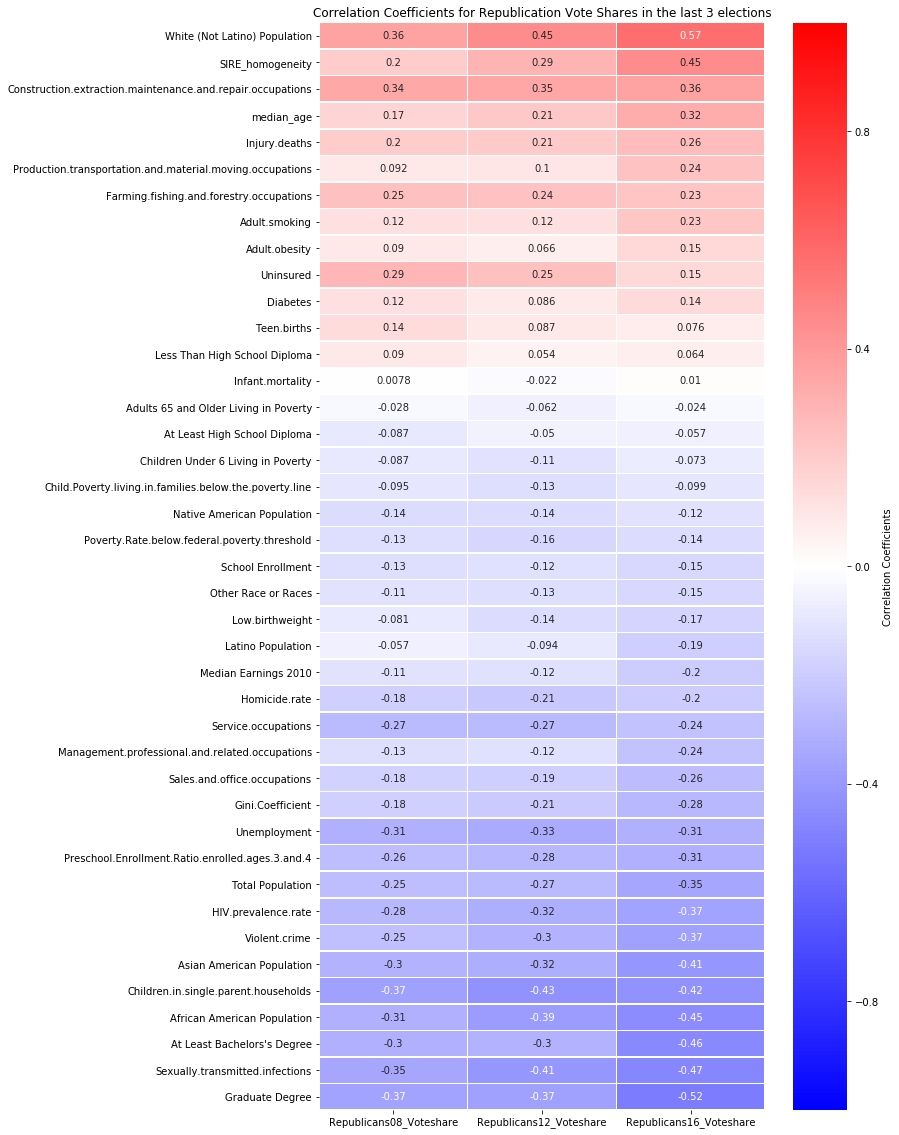

In [5]:
# calculate the correlation of demographics data and Republican vote shares
demographic_columns = df_merge.loc[:,'Less Than High School Diploma':'Infant.mortality'].columns
table = correlation_calc(df_merge,demographic_columns)

# Visualizing the correlations
title = "Correlation Coefficients for Republication Vote Shares in the last 3 elections"
seaborn_heatmap(table,title,fig_size = (10,20))

The strength of the correlation needs to be defined first before any meaningful discussion of the findings. The definition is as follows: ([source](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf))


| Strength | Correlation Coefficient |
|---|---|
| Very Weak | 0.00-0.19 |
| Weak | 0.20-0.39 |
| Moderate | 0.40-0.59 |
| Strong | 0.60-0.79 |
| Very Strong | 0.80-1.0 |


<i><u>Note -</i></u>
<br>
<i>Source cited in the article:
<br>
Evans, J.D. 1996. Straightforward Statistics for the Behavioral Sciences. Brooks/Cole Publishing; Pacific Grove, Calif.: 1996.</i>


Although there is no column that is strongly correlated to Republican vote share, the pattern of positive and negative correlation tend to stay consistent across all 3 elections.

The category with the highest positive correlation is *White population*, with a weak to moderate correlation between 0.36-0.57. It seems like Caucasians in particular have some influence to the Republican vote share.

The columns with the highest negative correlation is *Graduate degree*, also with a weak to moderate correlation across all 3 elections. This suggests that voters with a higher education tend to support the Democrats.

Columns with weak to no correlation are in the middle of the heatmap. Factors like *less than high school diploma*, *infant mortality* and *adult 65 and older living in poverty* seem to have weak to no correlation with Republican vote share. This could be because those who are affected cannot participate in the election, thus having minimal effect on the vote share.

------
### 2. How are the racial demographics correlated with Republican vote share? Is there any race which is consistently correlated with the Republican vote share? Are these correlations statistically significant?

First, a seaborn heatmap is used to visualize the correlation between racial demographics and Republican vote share.

Then, the statistical significance is calculated using Pearson r. The null and alternative hypothesis are as follows:

<u>Null hypothesis (Ho):</u> A particular race has **no correlation** with the republician vote shares in 2008, 2012 and 2016 respectively.

<u>Alternative hypothesis (Hi):</u> A particular race **has a correlation** with the republician vote share in 2008, 2012 and 2016 respectively.

Since multiple significant tests will be run, a Bonferroni correction will be done and the critical p-value (i.e alpha) will be adjusted to avoid p-hacking. The new alpha will be 0.05 divided by the number of tests, which is 18 in this case. More information on Bonferroni correction can be read [here](http://www.biostathandbook.com/multiplecomparisons.html).

In [6]:
def national_race_correlation():
    '''
    This function creates a seaborn heatmap for correlations at a national level.
    '''
    
    title = "Correlation between race and Republican vote share nationally in the last 3 elections"

    return seaborn_heatmap(table.iloc[6:12,:],title,fig_size = (10,4))

In [7]:
def pearsonsr_significance_test(df,columns_of_interest):
    '''
    This function calculates the statistical significance using Pearson r.
    
    Input:
    -----
    df : DataFrame to pull the information from
    columns_of_interest : The columns that significant correlations will be tested (against republic vote share)
    
    Returns:
    -------
    Either a statement stating all correlations are significant, or a statement indicating specific pairing 
    that are not statistically significant.
    
    '''
    
    vote_shares = ['Republicans08_Voteshare','Republicans12_Voteshare','Republicans16_Voteshare']
    
    
    significant_correlations = pd.DataFrame(columns=vote_shares,index=columns_of_interest)

    for vote_share in vote_shares:
        for column in columns_of_interest:
            r, p = stats.pearsonr(df[vote_share],df[column])
            if p < 0.05/18:
                significant_correlations.loc[column,vote_share] = 1
            else:
                significant_correlations.loc[column,vote_share] = 0
    
    if significant_correlations.values.sum() == len(vote_shares) * len(columns_of_interest):
        print('All correlations are significant')
    elif significant_correlations.values.sum() == 0:
        print('No correlations are significant')
    else:
        return significant_correlations

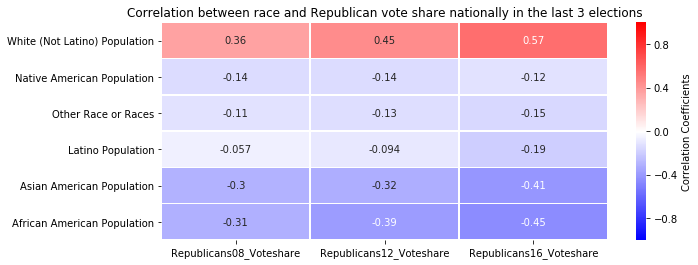

All correlations are significant


In [8]:
# visualizing the racial correlations
national_race_correlation()

# calculate the significance of the correlations
race_columns = df_merge.loc[:,'White (Not Latino) Population':'Latino Population'].columns
pearsonsr_significance_test(df_merge,race_columns)

From the heatmap above, White population shows weak to moderate positive correlations while all the remaining races correlated negatively across all 3 elections. 

For those races that are negatively correlated, African American population has the highest correlation between -0.31 to -0.45 nationally. 

Calculations from the Pearson r shows that all correlations have a p-value of less than the critical p-value, indicating we can reject the null hypothesis and conclude that all races have a significant correlation with Republican vote shares across all 3 elections.

### Bonus
------

While p-value is a metric to determine significance, using confidence intervals along with p-value would allow a more robust analysis, a wrapper function from this [source](https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/) is used to generate the confidence intervals along with the p-values.

For more information on confidence interval, please visit this [Wikipedia](https://en.wikipedia.org/wiki/Confidence_interval) page.

In [9]:
def pearsonr_ci(x,y,alpha=0.05/18):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [10]:
def pearsonsr_significance_test_ci(df,columns_of_interest):
    '''
    This function calculates the statistical significance using Pearson r.
    
    Input:
    -----
    df : DataFrame to pull the information from
    columns_of_interest : The columns that significant correlations will be tested (against republic vote share)
    
    Returns:
    -------
    Either a statement stating all correlations are significant, or a statement indicating specific pairing 
    that are not statistically significant.
    
    '''
    
    vote_shares = ['Republicans08_Voteshare','Republicans12_Voteshare','Republicans16_Voteshare']
    
    
    significant_correlations = pd.DataFrame(columns=vote_shares,index=columns_of_interest)

    for vote_share in vote_shares:
        for column in columns_of_interest:
            r,p,lo,hi = pearsonr_ci(df[vote_share],df[column],alpha=0.05)
            if p < 0.05/18 and (np.sign(lo) == np.sign(hi)):
                significant_correlations.loc[column,vote_share] = 1
            else:
                significant_correlations.loc[column,vote_share] = 0
    
    if significant_correlations.values.sum() == len(vote_shares) * len(columns_of_interest):
        print('All correlations are significant')
    elif significant_correlations.values.sum() == 0:
        print('No correlations are significant')
    else:
        return significant_correlations

In [11]:
# calculate the significance of the correlations, with confidence interval considered
pearsonsr_significance_test_ci(df_merge,race_columns)

All correlations are significant


Calculations from above shows that all correlations have a p-value of less than 0.05 as well as confidence interval that does not cross zero. When both conditions are satisified, we can reject the null hypothesis and conclude that all races have a significant correlation with Republican vote shares across all 3 elections.

------
### 3. Create 2 new dataframes: one containing only counties in California, the other containing only counties in Texas. Do the nationwide patterns that you found in the previous question still hold in these particular states? Which races remain positively (or negatively) correlated with a political party in each state? Are there races in California or Texas that have different correlations than the national trends?

First, the Republican vote shares are merged with the demographics data, then counties in California and Texas are filtered into separate dataframes - 

In [12]:
# creating 2 new dataframes containing information from counties in CA and TX
california = df_merge[df_merge["State"]=="California"]
texas = df_merge[df_merge["State"]=="Texas"]

### California racial correlations
------

Let's first compare the correlations between race and Republican vote shares nationally and in California.

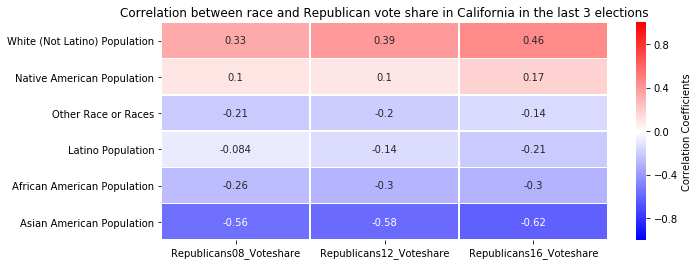

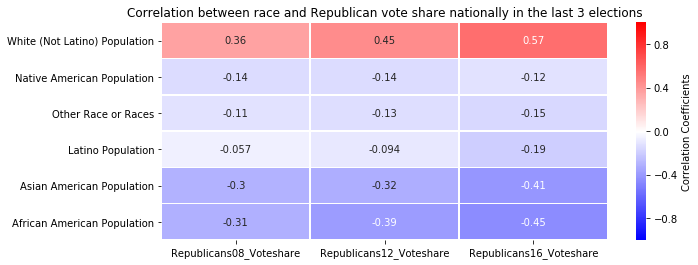

,Republicans08_Voteshare,Republicans12_Voteshare,Republicans16_Voteshare
White (Not Latino) Population,0,1,1
African American Population,0,0,0
Native American Population,0,0,0
Asian American Population,1,1,1
Other Race or Races,0,0,0
Latino Population,0,0,0


In [13]:
# Calculating the correlation for CA
table_ca = correlation_calc(california,race_columns)

# Creating the seaborn heatmap for CA
title = "Correlation between race and Republican vote share in California in the last 3 elections"
seaborn_heatmap(table_ca,title,fig_size = (10,4))

# Visualizing the national trend for comparison
national_race_correlation()

# Testing the significance for CA
pearsonsr_significance_test_ci(california,race_columns)

The DataFrame above shows the signifcance of each correlation. A `1` indicates a significant correlation for the particular race and vote share while `0` indicates no significance. Notice that, unlike the national correlation which were all significant, California's correlations are only significant in the Asian American population across all three elections and the white population in 2012 and 2016. 

Asian American population in California has a moderate to strong correlation with Republican vote share, which is higher than the correlations nationally. This could be due to the large presence of the Asian American population and the state being one of the most progressive in the country. On the other hand, White population has a similar strength of correlation with the Republican vote share versus nationally in 2012 and 2016.


### Texas racial correlations
------

Next, let's compare the correlations between race and Republican vote shares nationally and in Texas.

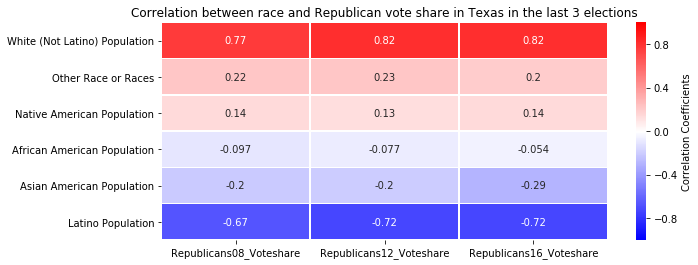

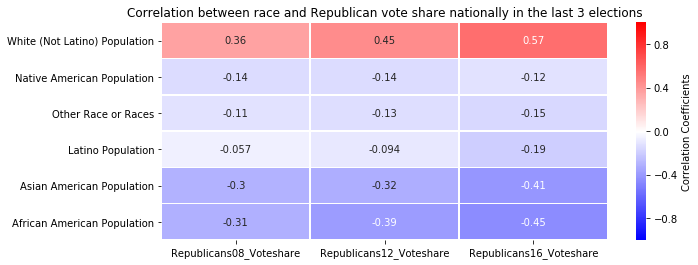

,Republicans08_Voteshare,Republicans12_Voteshare,Republicans16_Voteshare
White (Not Latino) Population,1,1,1
African American Population,0,0,0
Native American Population,0,0,0
Asian American Population,1,1,1
Other Race or Races,1,1,1
Latino Population,1,1,1


In [14]:
# Calculating the correlation for TX
table_tx = correlation_calc(texas,race_columns)

# Creating a heatmap of correlation for TX
title = "Correlation between race and Republican vote share in Texas in the last 3 elections"
seaborn_heatmap(table_tx,title,fig_size = (10,4))

# Visualizing the national trend for comparison
national_race_correlation()

# Testing the significance for TX
pearsonsr_significance_test_ci(texas,race_columns)

Here we can see that there are more significant correlations than California but still not as many as the national correlations. Surprisingly, the only racial demographics that aren't significantly correlated with republician vote share is the Africian American and Native American populations. Perhaps there is not enough democratic support in these populations in Texas to detect a significant correlation.

In terms of the strength of the correlation, it is evident that White population has a strong positive correlation to Republican vote share across all 3 elections compared to the weak and moderate correlations nationally. In contrast, Latino poplation has a strong negative correlation compared to a very weak correlation nationally. This speaks to the racial divide in the southern states and thus certain racial demographics being a more influential factor in the party vote shares.

## Analysis Part 3
------

### 1. At a county level visualize the percentage share of the Republican votes in each election. What visualization method is most appropriate for this task? (We are asking for three plots, one for each election.) What are some of the similarities and differences between the 3 elections?

A seaborn distplot is chosen for this task, since the distribution of the vote shares can be easily visualized and compared side-by-side.

In [15]:
def seaborn_distplot(data_1,data_2,ylim,bins,title):
    '''
    This function creates a seaborn distplot.
    
    Input:
    -----
    data_1 : data input for the 1st distribution
    data_2 : data input for the 2nd distribution
    ylim : y-limit of the graph
    bins : bin size of the plot
    title : Title of the graph
    
    Returns:
    -------
    A Seaborn heatmap
    '''
    
    sns.distplot(data_1, color = 'deepskyblue', kde = False, label = 'Democrats', bins = bins)
    sns.distplot(data_2, color = 'tomato', kde = False, label = 'Republicans', bins = bins)
    plt.xlabel("Vote shares")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.ylim(0, ylim);
    plt.xlim(0,1.0);
    plt.legend();

In [16]:
def part_3_plots(df,ylim,bins,level = "county"):
    '''
    This function creates 3 subplots of the seaborn distplot using the function seaborn_distplot().
    
    Input:
    -----
    df : DataFrame containing the data to be visualized
    ylim : y-limit of the graph
    bins : bin size of the plot
    level : whether the data is at a state or county level
    
    Returns:
    -------
    3 subplots of the seaborn displot
    
    '''
    
    plt.figure(figsize = (20,6))
    gridspec.GridSpec(1,3)

    plt.subplot2grid((1,3), (0,0))
    seaborn_distplot(df.iloc[:,-6],df.iloc[:,-5],ylim,bins,f"2008 election by {level}")

    plt.subplot2grid((1,3), (0,1))
    seaborn_distplot(df.iloc[:,-4],df.iloc[:,-3],ylim,bins,f"2012 election by {level}")

    plt.subplot2grid((1,3), (0,2))
    seaborn_distplot(df.iloc[:,-2],df.iloc[:,-1],ylim,bins,f"2016 election by {level}")

    return plt.show();

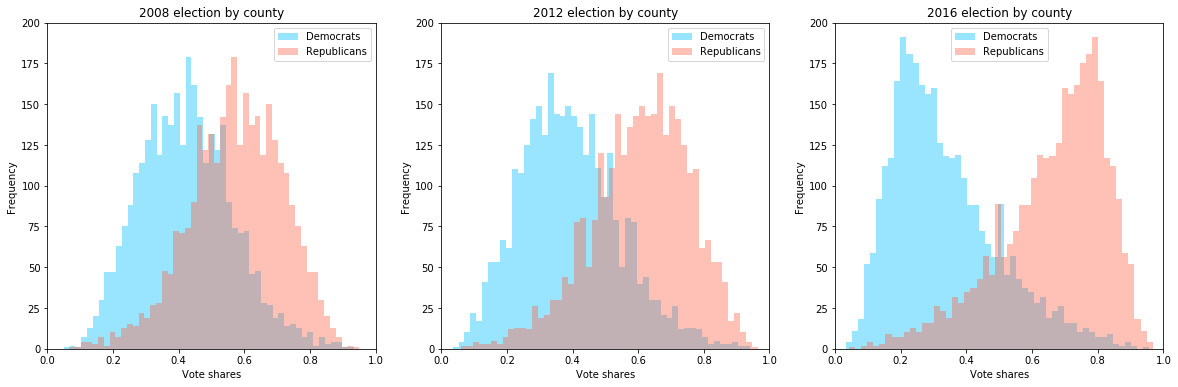

In [17]:
# Visualizing the vote shares
part_3_plots(df_votes,200,50,level = "county")

While the Republicans consistently receive a higher vote share across all 3 elections, the mode of the distribution drifts further apart from one election to the next. This suggests that Republicans are getting more votes with each election, which results in Republicans winning the 2016 election.

### 2. Repeat this exercise but now aggregate the data at a state level. (So instead of finding the vote share of a party within a county, find the vote share of a party within a state. Note: You might need to re-calculate the relative vote share for a state to take into account the different populations of each county.) Has your answer changed about the similarity of the 3 elections?

In [18]:
column_names = ['Democrats 08 (Votes)', 'Republicans 08 (Votes)','Democrats 12 (Votes)',
                'Republicans 12 (Votes)', 'votes16_clintonh','votes16_trumpd']

state_vote_shares = pd.DataFrame()

# calculating total votes for each party in each state, for each election
for column in column_names:
    state_vote_shares[f"{column}"] = df_merge[column].groupby(df_merge["State"]).sum()

# calculating total votes in each state for each election
for i,j,k in [(2008,0,1),(2012,2,3),(2016,4,5)]:
    state_vote_shares[f"total {i}"] = state_vote_shares.iloc[:,j] + state_vote_shares.iloc[:,k]

# calculating the relative vote shares of each state
year = 2008

for i in range(6):
    if i==0 or i%2==0:
        state_vote_shares[f"democrats {year} relative"] = state_vote_shares.iloc[:,i] / state_vote_shares[f"total {year}"]
    else:
        state_vote_shares[f"republicans {year} relative"] = state_vote_shares.iloc[:,i] / state_vote_shares[f"total {year}"]
        
    if i == 1 or i == 3:
        year += 4

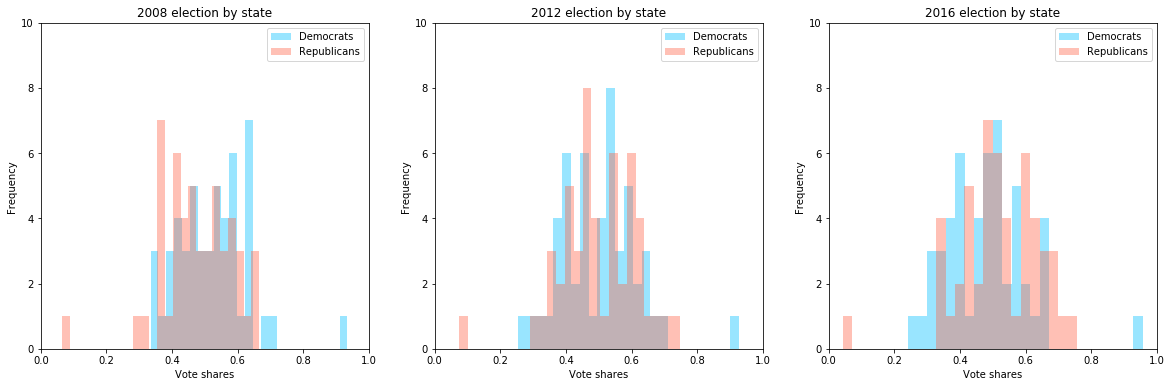

In [19]:
# Visualizing the relative vote share at a state level
part_3_plots(state_vote_shares,10,25,level = "state")

At the state level, the distribution of vote shares between Democrats and Republicans appears to be converging towards the centre which is the opposite of the trend observed at a county level. This indicates that at a state level, the gap between Democrats and Republicans are shrinking, which means Republicans are becoming more influential at a state level which has a direct relation to the electoral college votes that determine the winner of the presidential election.

### 3. Look back at the non-aggregated county-level data. Conduct one or more statistical tests to see whether the mean Republican party vote share across all of the counties are different for the 3 elections (Which statistical test is appropriate here? Assume that the people who voted in each county are a representative sample of its population.) Describe why you’ve chosen your tests and interpret your results.

Since we are comparing more than 2 groups of continuous data, ANOVA would be the appropriate choice of statistical test.

<u>Null hypothesis (Ho):</u> There is **no mean difference** in the Republican vote share across all the counties in 2008, 2012 and 2016 respectively.

<u>Alternative hypothesis (Hi):</u> There is **a mean difference** in the Republican vote share across all the counties in 2008, 2012 and 2016 respectively.

The critical p-value is set at 0.05.

In [20]:
# putting data into a format that is acceptable by statsmodel ANOVA
anova_table = pd.DataFrame(columns = ["Election","Vote_share"])
for i in range(-5,0,2):
    temp_table = pd.DataFrame({"Election": df_merge.columns[i], "Vote_share": df_merge.iloc[:,i]})
    anova_table = pd.concat([anova_table,temp_table])

# Performing ANOVA
info = ols("Vote_share ~ Election", data = anova_table).fit()
sm.stats.anova_lm(info,typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
Election,2.0,12.900524,6.450262,283.79834,2.081898e-120
Residual,9420.0,214.100854,0.022728,NaN,NaN


The ANOVA test above shows that the p-value (i.e PR(>F)) is less than 0.05, meaning we can reject the null hypothesis and conclude that there is a mean difference in the Republican vote shares in the 3 elections. 

However, we do not know whether the differences exist. Therefore, a Tukey Honest Significant (HSD) Test will be done to determine which pairing have a significant mean difference.

In [21]:
# Tukey HSD test
tukeyhsd = pairwise_tukeyhsd(anova_table["Vote_share"],anova_table["Election"])
print(tukeyhsd)

              Multiple Comparison of Means - Tukey HSD,FWER=0.05             
         group1                  group2         meandiff lower  upper  reject
-----------------------------------------------------------------------------
Republicans08_Voteshare Republicans12_Voteshare  0.0301  0.0212 0.0391  True 
Republicans08_Voteshare Republicans16_Voteshare  0.0891  0.0802 0.098   True 
Republicans12_Voteshare Republicans16_Voteshare  0.059    0.05  0.0679  True 
-----------------------------------------------------------------------------


From the results above, we can see that there are mean differences between Republican vote share between the 3 elections.

### BONUS
------

The non-parametric version of ANOVA is called the [Kruskal-Wallis H-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal). It has less assumptions than ANOVA and you can perform the test without doing any testing to confirm the assumptions.